# 1. Import & Setup

In [1]:
! pip uninstall -y protobuf
! pip install "protobuf==3.20.3"

Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; pyth

In [2]:
import os
import glob
import torch
import shutil
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from tqdm.notebook import tqdm
import numpy as np
import pickle

2025-11-18 17:45:08.607467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763487908.804000      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763487908.860073      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- CONFIGURATION ---
IMAGE_PATH = "/kaggle/input/clip-unsplash-lite-image-dataset/unsplash_images/*.jpg"

# Model: We use the base ViT patch 32. It's lighter than the 'large' model 
# but robust enough for semantic search.
MODEL_ID = "openai/clip-vit-base-patch32" 

BATCH_SIZE = 128 # Adjust based on GPU VRAM 

OUTPUT_DIR = "/kaggle/working/"

# Test Set

In [4]:
# The writable output directory for your test set
TEST_DIR = "/kaggle/working/test_images"

# 1. Clean/Create the test directory
if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)
os.makedirs(TEST_DIR)

# 2. Get list of all images
all_files = glob.glob(IMAGE_PATH)
print(f"Total images available: {len(all_files)}")

# 3. Select 100 random images
# We use a seed so you get the SAME test set every time you run this
random.seed(42)
test_files = random.sample(all_files, 100)

# 4. Copy them to the new folder
print(f"Copying {len(test_files)} images to {TEST_DIR}...")
for file_path in test_files:
    # Get the filename (e.g., 'image_01.jpg')
    file_name = os.path.basename(file_path)
    # Copy to new location
    shutil.copy(file_path, os.path.join(TEST_DIR, file_name))

print("Success! Test set created.")
print(f"Example test image path: {os.path.join(TEST_DIR, os.path.basename(test_files[0]))}")

Total images available: 24995
Copying 100 images to /kaggle/working/test_images...
Success! Test set created.
Example test image path: /kaggle/working/test_images/JymAEDgMK6U.jpg


# 2. Data Loading & Preprocessing 


# CLIP Image Processing and Index Construction

## 1. Data Transformation Pipeline
CLIP cannot process raw image files directly. Every image must first go through a multi-step preprocessing pipeline.

- **Resize and Center Crop**
  - Resize the image so its shortest side is `224px`.
  - Apply a center crop to create an exact \(224 \times 224\) pixel image.
- **Normalize**
  - Convert the RGB pixel values from a \([0, 255]\) range to a \([0, 1]\) range.
  - Normalize the pixel values using CLIP’s specific mean and standard deviation for each color channel.
- **Tensor Conversion**
  - Convert the preprocessed image into a PyTorch tensor.
  - The final tensor shape for a single image is `(3, 224, 224)`.
---
## 2. Batching
Processing images one by one is inefficient. Instead, multiple preprocessed images are stacked into a single batch to leverage parallel computation.

- For a batch size of 32, the resulting tensor shape becomes `(32, 3, 224, 224)`.
- Each element along the first dimension of the batch is a single preprocessed image tensor.
---
## 3. Encoding (Inference)
The batched image tensor is passed through the CLIP image encoder to generate numerical representations, or embeddings.

- **Input**: A batch tensor with a shape like `(32, 3, 224, 224)`.
- The model processes the visual features for every image in the batch simultaneously.
- **Output**: A batch of embedding vectors with a shape of `(32, 512)`. Each image is now represented as a 512-dimensional vector.




# Dataset Class 

In [5]:
class UnsplashDataset(Dataset):
    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Lazy Loading: We only open the image when the Dataloader asks for it.
        image_path = self.image_paths[idx]
        
        try:
            # 2. Convert to RGB: CLIP expects 3 channels. 
            # Some JPEGs might be grayscale (1 channel) or CMYK (4 channels).
            image = Image.open(image_path).convert("RGB")
            
            # 3. Processor Magic: This handles the raw preprocessing:
            #    - Resizes image to 224x224
            #    - Normalizes pixel values (Mean/Std) based on CLIP training data
            #    - return_tensors="pt" gives us PyTorch tensors
            pixel_values = self.processor(images=image, return_tensors="pt").pixel_values
            
            # 4. Squeeze: The processor adds a batch dim (1, 3, 224, 224). 
            # We remove it here because the DataLoader adds it back later.
            return {"pixel_values": pixel_values.squeeze(0), "path": image_path}
            
        except Exception as e:
            # 5. Error Handling: If an image is corrupt, we return None.
            # Standard datasets would crash the whole training loop here.
            return None

In [6]:
# Initialize Hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load Model Architecture and Weights
print("Loading CLIP model...")
model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

# Get file list
all_image_paths = glob.glob(IMAGE_PATH)
print(f"Found {len(all_image_paths)} images.")

def collate_fn(batch):
    # batch is a list of dictionaries returned by __getitem__
    # 1. Filter out the 'None' values (corrupt images)
    batch = [item for item in batch if item is not None]
    
    # 2. Edge case: If the whole batch was corrupt, return None
    if len(batch) == 0:
        return None
    
    # 3. Stack: Convert list of individual tensors into one Batch Tensor
    # Shape becomes: (Batch_Size, 3, 224, 224)
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    paths = [item["path"] for item in batch]
    
    return pixel_values, paths

# Initialize the Loader
# num_workers=2 allows the CPU to process the NEXT batch while GPU processes CURRENT batch
dataset = UnsplashDataset(all_image_paths, processor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, collate_fn=collate_fn)

Using device: cuda
Loading CLIP model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Found 24995 images.


# The Inference Loop (Normalization)

In [7]:
print("Starting extraction...")
all_embeddings = []
all_paths = []

# 1. Eval Mode: Disables Dropout and Batch Norm updates. Essential for deterministic inference.
model.eval() 

# 2. No Grad: Tells PyTorch not to calculate gradients for backprop. 
# Saves massive amounts of RAM and Compute.
with torch.no_grad():
    for batch in tqdm(dataloader):
        # Skip empty batches (from corruption)
        if batch is None: continue
        
        pixel_values, paths = batch
        pixel_values = pixel_values.to(device)
        
        # 3. Forward Pass: The images flow through the Vision Transformer.
        # Output shape: (Batch_Size, 512)
        image_features = model.get_image_features(pixel_values)
        
        # 4. L2 Normalization :
        # We divide the vector by its length (norm). 
        # This makes the vector length = 1. 
        # Why? Because Cosine Similarity == Dot Product if vectors are normalized.
        # This makes the search mathematical operation much faster later.
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        
        # 5. Detach & CPU: Move data off GPU to System RAM to free up VRAM for next batch
        all_embeddings.append(image_features.cpu().numpy())
        all_paths.extend(paths)

Starting extraction...


  0%|          | 0/196 [00:00<?, ?it/s]

# Serialization

In [8]:
# Stack list of arrays into one big (N, 512) matrix
final_embeddings = np.vstack(all_embeddings)

print(f"Extraction complete. Matrix Shape: {final_embeddings.shape}")

# Save Vectors
with open(os.path.join(OUTPUT_DIR, "image_embeddings.pkl"), "wb") as f:
    pickle.dump(final_embeddings, f)

# Save File Paths (so we know which vector belongs to which image)
with open(os.path.join(OUTPUT_DIR, "image_filenames.pkl"), "wb") as f:
    pickle.dump(all_paths, f)

print("Saved embeddings and filenames to /kaggle/working/")

Extraction complete. Matrix Shape: (24995, 512)
Saved embeddings and filenames to /kaggle/working/


# 3. Query Search & Visiualization

In [9]:
import matplotlib.pyplot as plt

# CONFIGURATION 
WORKING_DIR = "/kaggle/working/"


# LOAD EMBEDDINGS 
print("Loading index...")
with open(os.path.join(WORKING_DIR, "image_embeddings.pkl"), "rb") as f:
    image_embeddings = pickle.load(f)
    
with open(os.path.join(WORKING_DIR, "image_filenames.pkl"), "rb") as f:
    image_filenames = pickle.load(f)

# Convert to PyTorch Tensor for fast GPU calculation
image_embeddings = torch.tensor(image_embeddings).to(device)

print(f"Loaded {len(image_filenames)} images. Index shape: {image_embeddings.shape}")

# We re-load the model to encode user queries.
model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

Loading index...
Loaded 24995 images. Index shape: torch.Size([24995, 512])


# Define the Search Function

In [10]:
def search(query_text, top_k=5):
    # 1. Encode the Text Query
    inputs = processor(text=[query_text], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    
    # 2. Normalize the Query 
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    
    # 3. Compute Similarity 
    # Shape: (1, 512) @ (512, 25000) -> (1, 25000)
    similarities = (text_features @ image_embeddings.T).squeeze(0)
    
    # 4. Get Top-K matches
    # values: scores, indices: position in the array
    values, indices = similarities.topk(top_k)
    
    # 5. Retrieve File Paths
    results = []
    for score, idx in zip(values, indices):
        results.append({
            "path": image_filenames[idx.item()],
            "score": score.item()
        })
    return results

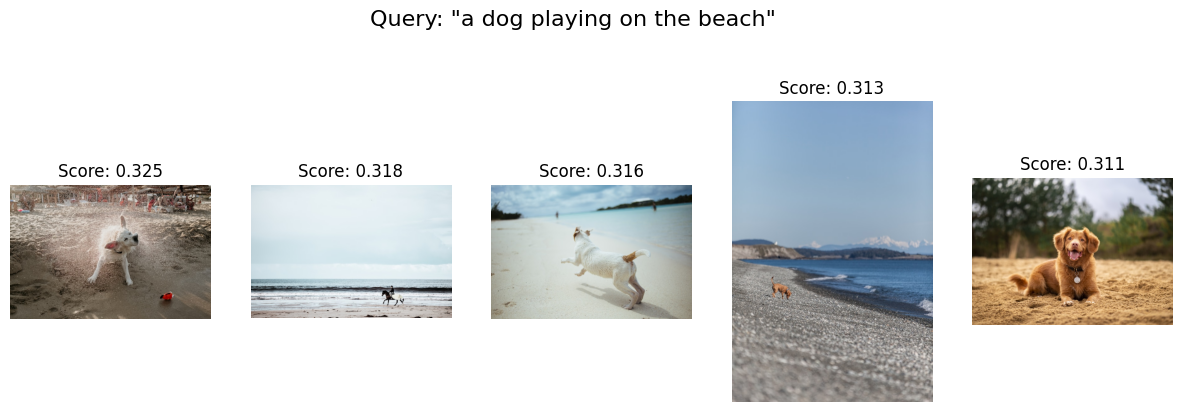

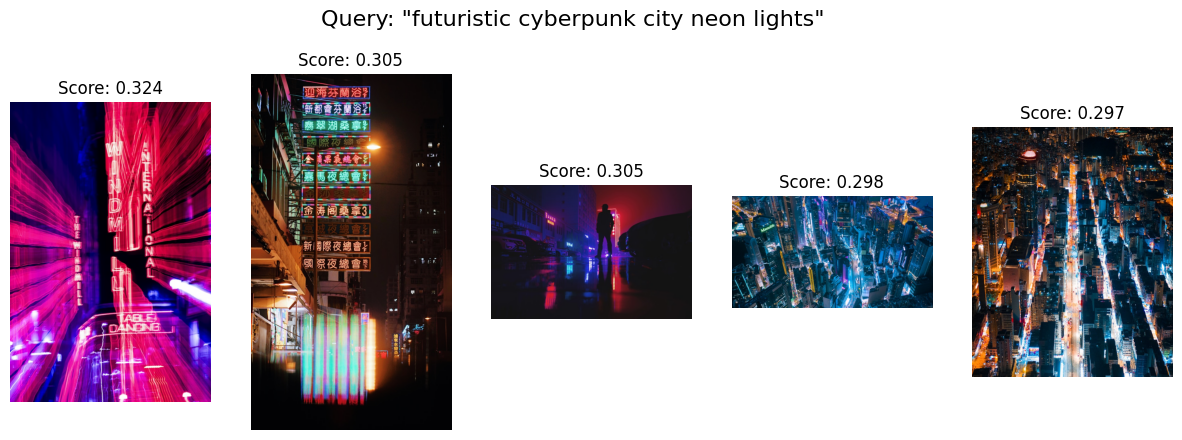

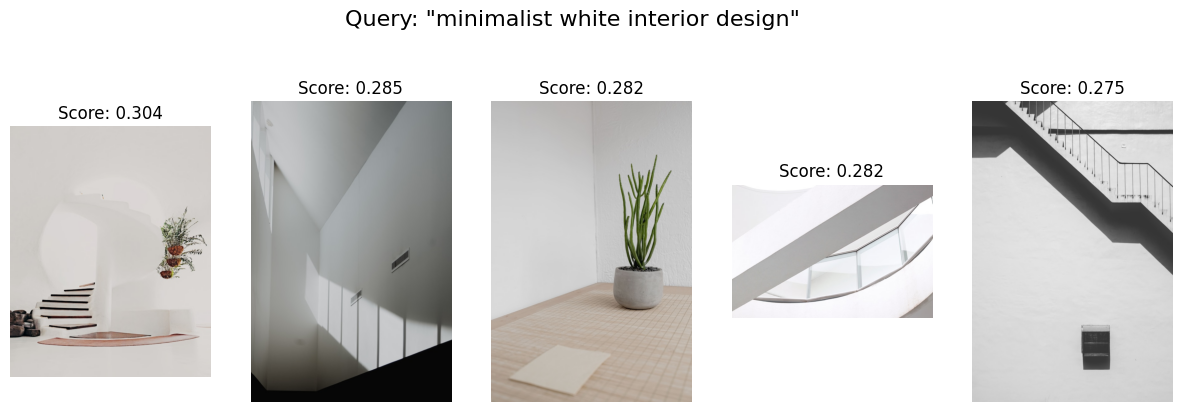

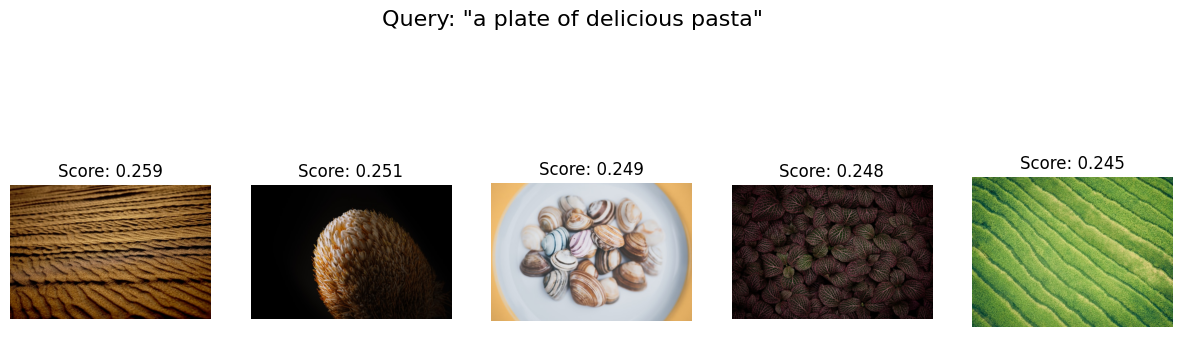

In [11]:
def visualize_results(query, results):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Query: "{query}"', fontsize=16)
    
    for i, res in enumerate(results):
        path = res['path']
        score = res['score']
        
        try:
            img = Image.open(path).convert("RGB")
            plt.subplot(1, len(results), i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Score: {score:.3f}")
        except Exception as e:
            print(f"Could not load image: {path}")
            
    plt.show()

# --- INTERACTIVE TEST ---

queries = [
    "a dog playing on the beach",
    "futuristic cyberpunk city neon lights",
    "minimalist white interior design",
    "a plate of delicious pasta"
]

for q in queries:
    hits = search(q, top_k=5)
    visualize_results(q, hits)

- **Score Distribution:**

- Scores > 0.30 are usually strong matches.

- Scores < 0.20 are often weak or irrelevant matches.

- Note: Since these are high-dimensional vectors, scores typically range from 0.15 to 0.35, not 0.0 to 1.0. This is normal behavior for CLIP

# 4. Zero-Shot Classification

- **Concept**: Instead of training a model to recognize specific classes (like "cat" vs "dog"), It uses the text encoder to create a classifier on the fly. It essentially ask the model: "Which of these captions best matches this image?"

Selected 3 random images for testing...

--- Analyzing: kbz6BxX874M.jpg ---


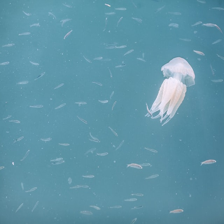

🏆 Prediction: FLOWER (54.8%)
Top Scores:
  - flower: 54.8%
  - mountain: 25.6%
  - car: 9.1%
  - city: 5.6%
  - forest: 4.9%


--- Analyzing: loP8xxkZIk8.jpg ---


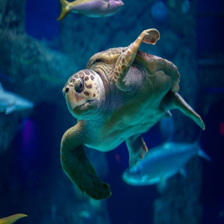

🏆 Prediction: FLOWER (53.6%)
Top Scores:
  - flower: 53.6%
  - forest: 18.7%
  - mountain: 11.7%
  - car: 9.0%
  - city: 6.9%


--- Analyzing: grNueWoVnQ4.jpg ---


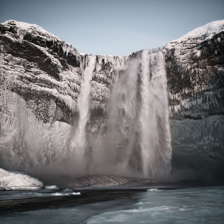

🏆 Prediction: MOUNTAIN (90.8%)
Top Scores:
  - mountain: 90.8%
  - city: 4.8%
  - car: 2.8%
  - forest: 1.4%
  - flower: 0.2%




In [12]:

# --- CONFIGURATION ---
TEST_DIR = "/kaggle/working/test_images"
NO_OF_TEST_IMAGES = 3

# Define classes that might actually exist in Unsplash data
classes = ["forest", "car", "city", "mountain", "flower"] 

# --- DEFINE CLASSIFIER FUNCTION ---
def zero_shot_classify(image_path, candidate_labels, model, processor, device):
    # 1. Prepare Prompt
    text_inputs = [f"a photo of a {label}" for label in candidate_labels]
    
    # 2. Load Image
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        return None

    # 3. Preprocess
    inputs = processor(
        text=text_inputs, 
        images=image, 
        return_tensors="pt", 
        padding=True
    ).to(device)

    # 4. Inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 5. Probabilities
    # logits_per_image shape: (1, num_classes)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1).cpu().numpy().flatten()
    
    # 6. Result
    predicted_idx = np.argmax(probs)
    
    return {
        "label": candidate_labels[predicted_idx],
        "confidence": probs[predicted_idx],
        "all_scores": dict(zip(candidate_labels, probs))
    }

# --- RUN PREDICTION ---

# 1. Get list of all available test images

if os.path.exists(TEST_DIR):
    all_test_files = os.listdir(TEST_DIR)
    
    if len(all_test_files) > 0:
        # 2. Pick random images
        count = min(NO_OF_TEST_IMAGES, len(all_test_files))
        selected_files = random.sample(all_test_files, count)
        print(f"Selected {len(selected_files)} random images for testing...\n")

        # 3. LOOP THROUGH SELECTED IMAGES
        for file_name in selected_files:
            # Construct path dynamically here
            current_image_path = os.path.join(TEST_DIR, file_name)
            
            print(f"--- Analyzing: {file_name} ---")
            
            # Run classification
            result = zero_shot_classify(
                current_image_path, 
                classes, 
                model, 
                processor, 
                device
            )

            if result:
                # Visual Output
                display(Image.open(current_image_path).resize((224, 224)))
                
                print(f"🏆 Prediction: {result['label'].upper()} ({result['confidence']:.1%})")
                
                # Show top scores
                sorted_scores = sorted(result['all_scores'].items(), key=lambda x: x[1], reverse=True)
                print("Top Scores:")
                for label, score in sorted_scores:
                    print(f"  - {label}: {score:.1%}")
                print("\n")
            else:
                print(f"Could not load {file_name}\n")
    else:
        print(f"No images found in {TEST_DIR}")
else:
    print(f"Directory {TEST_DIR} does not exist. Did you run the test set setup script?")

# 5. Few-Shot Learning

- **Concept**: You give the model a tiny amount of labeled data (e.g., 4 images of "defective" parts and 4 images of "good" parts) and it learns to classify them.

- Since CLIP features are so robust, we don't need to retrain the heavy Transformer model. We use a technique called **Linear Probing**: we train a lightweight classifier (like Logistic Regression) on top of the frozen CLIP embeddings.

**"Active Learning" Simulation**
We need a little labeled data for few shot learning, since our dataset is unlabeled, we face a challenge: How do we get the "labels" (0s and 1s) to train the Few-Shot classifier?

- The Engineering Solution: We will use your existing Search Engine to "mine" the training data.

1. Mine Data: Search for "Forest" → Take Top 5 images. Search for "City" → Take Top 5 images.

2. Label Data: Assign 0 to the forest images and 1 to the city images.

3. Train: Train the Logistic Regression on these 10 images.

4. Test: Run the classifier on your Test Set (the 100 hold-out images) to see if it generalizes.

In [13]:
from sklearn.linear_model import LogisticRegression

def train_few_shot_classifier(train_images, train_labels, model, processor, device):
    """
    Trains a Logistic Regression classifier on top of frozen CLIP features.
    This is NOT fine-tuning (backprop). It is "Linear Probing".
    """
    print(f"⚙️ Extracting features for {len(train_images)} training images...")
    
    embeddings = []
    model.eval()
    
    with torch.no_grad():
        for img_path in train_images:
            try:
                image = Image.open(img_path).convert("RGB")
                # Preprocess and move to GPU
                inputs = processor(images=image, return_tensors="pt").to(device)
                
                # Get CLIP Embedding (512-dim vector)
                image_features = model.get_image_features(**inputs)
                
                # Normalize (Critical for Linear Probes on Cosine-Similarity trained models)
                image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
                
                # Move to CPU for Scikit-Learn
                embeddings.append(image_features.cpu().numpy().flatten())
            except Exception as e:
                print(f"Skipping corrupt image: {img_path}")

    # Prepare X (Features) and y (Labels)
    X_train = np.array(embeddings)
    y_train = np.array(train_labels)
    
    # Train the "Probe" (Logistic Regression)
    # C=0.316 is a hyperparameter optimized for normalized features
    print("🧠 Training Logistic Regression...")
    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=0)
    classifier.fit(X_train, y_train)
    
    return classifier

In [14]:
def get_top_images_for_concept(concept_text, n=5):
    """Uses your existing Search Engine to find training examples."""
    inputs = processor(text=[concept_text], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        text_feat = model.get_text_features(**inputs)
    text_feat /= text_feat.norm(dim=-1, keepdim=True)
    
    # Similarity search against the cached index 
    sims = (text_feat @ image_embeddings.T).squeeze(0)
    indices = sims.topk(n).indices.cpu().numpy()
    
    return [image_filenames[i] for i in indices]

⛏️ Mining ROBUST training data...
  - Class 0 (Nature): 30 images
  - Class 1 (Architecture): 25 images
🧠 Training Robust Classifier...
✅ Classifier Upgraded.

--- 🧪 Re-Evaluation on Test Images ---


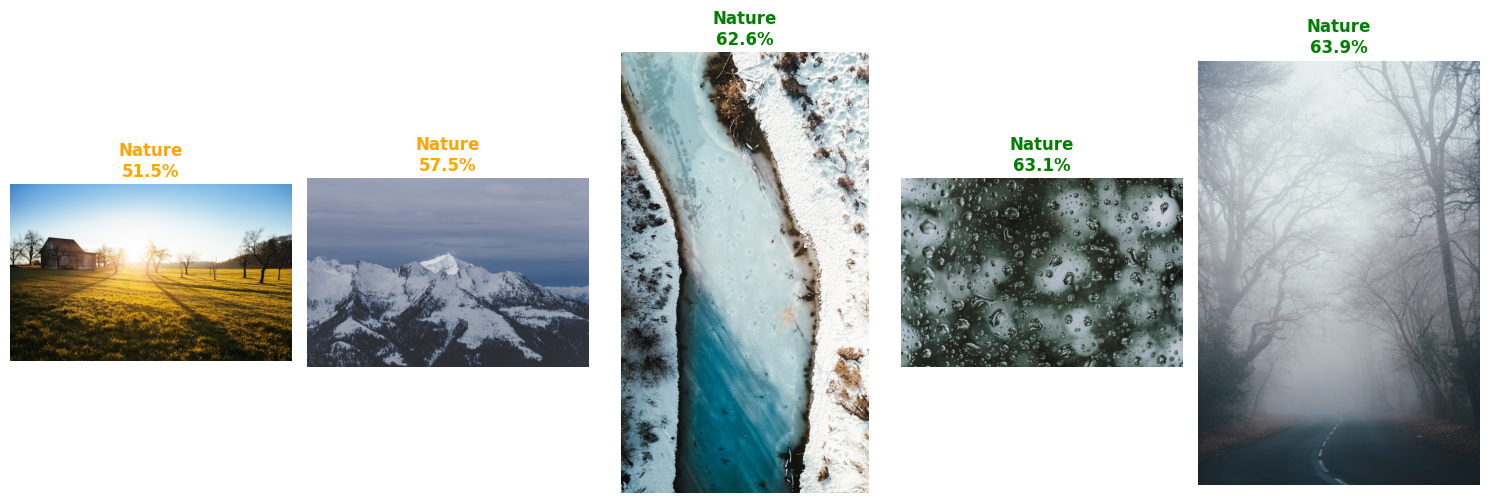

In [15]:
# --- 1. SETUP & HELPER FUNCTIONS ---

# Define Classes
class_names = {0: "Nature", 1: "Architecture"}

# Helper: Extract Feature for a single image
def get_image_feature(path):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        feature = model.get_image_features(**inputs)
    # Normalize!
    return feature.cpu().numpy().flatten() / np.linalg.norm(feature.cpu().numpy())

# Helper: Predict
def predict_few_shot(classifier, image_path, model, processor, device):
    try:
        feature = get_image_feature(image_path)
        pred = classifier.predict([feature])[0]
        probs = classifier.predict_proba([feature])[0]
        return pred, probs
    except:
        return None, None

# --- 2. MINE ROBUST DATA  ---
print("⛏️ Mining ROBUST training data...")

nature_queries = [
    "forest trees woods", 
    "mountain rocks canyon cliff", 
    "beach ocean water sea", 
    "wildlife animal jellyfish bird",   
    "flowers plants macro close-up",    
    "night sky stars dark nature"       
]

arch_queries = [
    "modern city skyscraper skyline", 
    "old historic building castle", 
    "interior room furniture design",
    "bridge road highway infrastructure",
    "still life objects table"          
]

nature_files = []
for q in nature_queries:
    # Reuse your existing search helper
    nature_files.extend(get_top_images_for_concept(q, n=5))

city_files = []
for q in arch_queries:
    city_files.extend(get_top_images_for_concept(q, n=5))

# Combine
few_shot_train_images = nature_files + city_files
few_shot_train_labels = [0] * len(nature_files) + [1] * len(city_files)

print(f"  - Class 0 (Nature): {len(nature_files)} images")
print(f"  - Class 1 (Architecture): {len(city_files)} images")

# --- 3. TRAIN CLASSIFIER ---
print("🧠 Training Robust Classifier...")

# Extract features for all training images
X_train = []
valid_labels = []

for img_path, label in zip(few_shot_train_images, few_shot_train_labels):
    try:
        feat = get_image_feature(img_path)
        X_train.append(feat)
        valid_labels.append(label)
    except:
        continue

fs_classifier = LogisticRegression(random_state=0, C=1.0, max_iter=1000, verbose=0)
fs_classifier.fit(X_train, valid_labels)

print("✅ Classifier Upgraded.")

# --- 4. EVALUATE  ---
print("\n--- 🧪 Re-Evaluation on Test Images ---")

test_dir = "/kaggle/working/test_images"
if os.path.exists(test_dir):
    all_test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
    # Pick 5 random images to visualize
    sample_test_files = random.sample(all_test_files, min(5, len(all_test_files)))
    
    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(sample_test_files):
        pred_idx, pred_probs = predict_few_shot(fs_classifier, img_path, model, processor, device)
        
        if pred_idx is not None:
            pred_name = class_names[pred_idx]
            confidence = pred_probs[pred_idx]
            
            img = Image.open(img_path).convert("RGB")
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
            
            # Green title if confident (>60%), Orange if uncertain
            color = "green" if confidence > 0.6 else "orange"
            plt.title(f"{pred_name}\n{confidence:.1%}", color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("Test directory not found! Run the test set creation script first.")